In [1]:
!pip install --upgrade tensorflow-gpu==2.0

Requirement already up-to-date: tensorflow-gpu==2.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (2.0.0)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
%%time

input_data = 's3://osanusi-auto/preprocessed_frl_fake.csv'
news_df = pd.read_csv(input_data)
news_df.head()

CPU times: user 38.4 s, sys: 5.4 s, total: 43.8 s
Wall time: 2min 25s


,domain,content,scraped_at,title,label,day_name
0,nytimes,month threejudge panel federal appeal court re...,2018-02-11 00:42:14.935145+00:00,appeal challenge child,real,sunday
1,yahoo,stockholm reuters sweden seek assurance presid...,2016-11-11 14:16:53.754000+00:00,sweden seek assurance trump defense agreement,real,friday
2,nytimes,week bus practice gained widespread publicity ...,2018-02-11 00:45:31.225957+00:00,brooklyn clash religious woman right,real,sunday
3,yahoo,beirut latest development syria backed kurdish...,2016-11-08 03:28:07.118000+00:00,latest turkey kurd naive,real,tuesday
4,sfgate,hotshooting tennessee tech rout alabama publis...,2016-11-18 22:38:10.550000+00:00,hotshooting tennessee tech rout alabama sfgate,real,friday


In [4]:
news_df.isnull().sum()

domain            0
content          18
scraped_at        0
title         12629
label             0
day_name          0
dtype: int64

In [5]:
news_df.dropna(inplace=True)
news_df.isnull().sum()

domain        0
content       0
scraped_at    0
title         0
label         0
day_name      0
dtype: int64

In [6]:
news_df.shape

(1775353, 6)

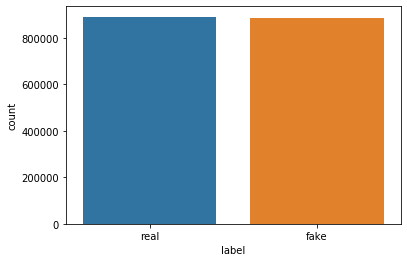

In [7]:
sns.countplot(x='label', data=news_df)

In [8]:
news_df_true = news_df[news_df['label'] == 'real']
news_df_true.head()

,domain,content,scraped_at,title,label,day_name
0,nytimes,month threejudge panel federal appeal court re...,2018-02-11 00:42:14.935145+00:00,appeal challenge child,real,sunday
1,yahoo,stockholm reuters sweden seek assurance presid...,2016-11-11 14:16:53.754000+00:00,sweden seek assurance trump defense agreement,real,friday
2,nytimes,week bus practice gained widespread publicity ...,2018-02-11 00:45:31.225957+00:00,brooklyn clash religious woman right,real,sunday
3,yahoo,beirut latest development syria backed kurdish...,2016-11-08 03:28:07.118000+00:00,latest turkey kurd naive,real,tuesday
4,sfgate,hotshooting tennessee tech rout alabama publis...,2016-11-18 22:38:10.550000+00:00,hotshooting tennessee tech rout alabama sfgate,real,friday


In [9]:
news_df_true.tail()

,domain,content,scraped_at,title,label,day_name
893995,nytimes,washington beijing advanced comprehensive stra...,2018-02-11 00:48:08.178739+00:00,china test diplomacy south sudan,real,sunday
893996,sfgate,close image presidentelect donald trump wave c...,2016-11-22 23:49:50.390000+00:00,trump disavows altright white supremacist,real,tuesday
893997,nytimes,executive real estate partnership controlled c...,2018-02-11 00:40:14.183931+00:00,metro briefing jersey newark kushner executive...,real,sunday
893998,nytimes,professor cowen expert economics culture art c...,2018-02-11 00:46:01.049401+00:00,economic theory plot course good food,real,sunday
893999,nytimes,advice taken album including sold million copy...,2018-02-11 00:37:28.456809+00:00,jersey footlights,real,sunday


In [10]:
news_df_fake = news_df[news_df['label'] == 'fake']
news_df_fake.head()

,domain,content,scraped_at,title,label,day_name
894000,beforeitsnews,obama administration immigrant come america fr...,2017-11-21 12:56:35.440396+00:00,obama administration immigrant come america fr...,fake,tuesday
894001,beforeitsnews,taking step respect bataan memorial death marc...,2017-11-27 01:14:08.745400+00:00,taking step respect bataan memorial death march,fake,monday
894002,threepercenternation,austin texas state legalize open carry handgun...,2017-11-27 01:15:32.269834+00:00,thousand shot texas legalized open carry peopl...,fake,monday
894003,threepercenternation,food stamp similar program help million people...,2017-11-27 01:15:32.269834+00:00,shopper picked receipt dropped shocked balance,fake,monday
894004,beforeitsnews,panasonic historic royal palace announce corpo...,2017-11-18 20:01:27.400599+00:00,panasonic historic royal palace announce corpo...,fake,saturday


In [11]:
news_df_fake.tail()

,domain,content,scraped_at,title,label,day_name
1787994,beforeitsnews,downgrade spain credit rating news troubled eu...,2017-11-27 01:14:08.745400+00:00,downgrade spain credit rating,fake,monday
1787995,dailyheadlines,dailyheadlines privacy visitor extreme importa...,2017-11-18 20:01:27.400599+00:00,privacy policy,fake,saturday
1787996,coed,catherine deneuve turn year todaybut thats sur...,2017-11-27 01:14:21.395055+00:00,catherine deneuve sexy photo birthday,fake,monday
1787998,ushealthyadvisor,president trump reported wednesday united stat...,2017-11-27 01:15:37.733539+00:00,military archive,fake,monday
1787999,beforeitsnews,procyclicalists atlantic news preceding post b...,2017-11-27 01:14:08.745400+00:00,procyclicalists atlantic,fake,monday


In [12]:
news_df['all_text'] = news_df['title'] + ' ' + news_df['content']
news_df.head()

,domain,content,scraped_at,title,label,day_name,all_text
0,nytimes,month threejudge panel federal appeal court re...,2018-02-11 00:42:14.935145+00:00,appeal challenge child,real,sunday,appeal challenge child month threejudge panel ...
1,yahoo,stockholm reuters sweden seek assurance presid...,2016-11-11 14:16:53.754000+00:00,sweden seek assurance trump defense agreement,real,friday,sweden seek assurance trump defense agreement ...
2,nytimes,week bus practice gained widespread publicity ...,2018-02-11 00:45:31.225957+00:00,brooklyn clash religious woman right,real,sunday,brooklyn clash religious woman right week bus ...
3,yahoo,beirut latest development syria backed kurdish...,2016-11-08 03:28:07.118000+00:00,latest turkey kurd naive,real,tuesday,latest turkey kurd naive beirut latest develop...
4,sfgate,hotshooting tennessee tech rout alabama publis...,2016-11-18 22:38:10.550000+00:00,hotshooting tennessee tech rout alabama sfgate,real,friday,hotshooting tennessee tech rout alabama sfgate...


In [13]:
df_real_smpl = news_df_true.sample(n = 400000, random_state = 1)

In [14]:
df_real_smpl.shape

(400000, 6)

In [15]:
df_fake_smpl = news_df_fake.sample(n = 400000, random_state = 1)

In [16]:
df_fake_smpl.shape

(400000, 6)

In [17]:
df_sample = pd.concat([df_real_smpl, df_fake_smpl])

In [18]:
df_sample.head()

,domain,content,scraped_at,title,label,day_name
119963,nytimes,passed away peacefully natural cause annapolis...,2018-02-11 00:47:27.911913+00:00,paid notice death zimmerman charles,real,sunday
471384,nytimes,proposed ban backlash regionwide proliferation...,2018-02-11 00:42:16.294886+00:00,store unmoored bank,real,sunday
256102,nytimes,editor survivor open heart surgery read articl...,2018-02-11 00:39:03.847149+00:00,performing scan heart,real,sunday
880206,nytimes,havent seen roger pitch person year stottlemyr...,2018-02-11 00:41:30.752058+00:00,clemens work success,real,sunday
689524,nytimes,alexandra stevenson tennis simply know grief r...,2018-02-11 00:36:28.156074+00:00,stevenson upset capriati,real,sunday


In [19]:
df_sample['all_text'] = df_sample['title'] + ' ' + df_sample['content']
df_sample.head()

,domain,content,scraped_at,title,label,day_name,all_text
119963,nytimes,passed away peacefully natural cause annapolis...,2018-02-11 00:47:27.911913+00:00,paid notice death zimmerman charles,real,sunday,paid notice death zimmerman charles passed awa...
471384,nytimes,proposed ban backlash regionwide proliferation...,2018-02-11 00:42:16.294886+00:00,store unmoored bank,real,sunday,store unmoored bank proposed ban backlash regi...
256102,nytimes,editor survivor open heart surgery read articl...,2018-02-11 00:39:03.847149+00:00,performing scan heart,real,sunday,performing scan heart editor survivor open hea...
880206,nytimes,havent seen roger pitch person year stottlemyr...,2018-02-11 00:41:30.752058+00:00,clemens work success,real,sunday,clemens work success havent seen roger pitch p...
689524,nytimes,alexandra stevenson tennis simply know grief r...,2018-02-11 00:36:28.156074+00:00,stevenson upset capriati,real,sunday,stevenson upset capriati alexandra stevenson t...


In [20]:
%%time

maxlen = -1
for doc in df_sample.all_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 13907
CPU times: user 17min 45s, sys: 0 ns, total: 17min 45s
Wall time: 17min 45s


In [21]:
df_sample['all_words'] = df_sample['all_text'].str.split()

In [22]:
df_sample.head()

,domain,content,scraped_at,title,label,day_name,all_text,all_words
119963,nytimes,passed away peacefully natural cause annapolis...,2018-02-11 00:47:27.911913+00:00,paid notice death zimmerman charles,real,sunday,paid notice death zimmerman charles passed awa...,"[paid, notice, death, zimmerman, charles, pass..."
471384,nytimes,proposed ban backlash regionwide proliferation...,2018-02-11 00:42:16.294886+00:00,store unmoored bank,real,sunday,store unmoored bank proposed ban backlash regi...,"[store, unmoored, bank, proposed, ban, backlas..."
256102,nytimes,editor survivor open heart surgery read articl...,2018-02-11 00:39:03.847149+00:00,performing scan heart,real,sunday,performing scan heart editor survivor open hea...,"[performing, scan, heart, editor, survivor, op..."
880206,nytimes,havent seen roger pitch person year stottlemyr...,2018-02-11 00:41:30.752058+00:00,clemens work success,real,sunday,clemens work success havent seen roger pitch p...,"[clemens, work, success, havent, seen, roger, ..."
689524,nytimes,alexandra stevenson tennis simply know grief r...,2018-02-11 00:36:28.156074+00:00,stevenson upset capriati,real,sunday,stevenson upset capriati alexandra stevenson t...,"[stevenson, upset, capriati, alexandra, steven..."


In [23]:
df_sample.tail()

,domain,content,scraped_at,title,label,day_name,all_text,all_words
1533856,beforeitsnews,secret holy menacuddle cornwall druid chair re...,2017-11-18 20:01:27.400599+00:00,secret holy menacuddle cornwall druid chair,fake,saturday,secret holy menacuddle cornwall druid chair se...,"[secret, holy, menacuddle, cornwall, druid, ch..."
1298919,beforeitsnews,california shameless antigun political theater...,2017-11-27 01:14:08.745400+00:00,california shameless antigun political theater...,fake,monday,california shameless antigun political theater...,"[california, shameless, antigun, political, th..."
1334429,therightscoop,love rush taking obamas word turning classic t...,2017-11-27 01:15:32.269834+00:00,rush obama debate arizona immigration,fake,monday,rush obama debate arizona immigration love rus...,"[rush, obama, debate, arizona, immigration, lo..."
1573102,beforeitsnews,hollywood secret rabbit hole reader think stor...,2017-11-27 01:14:08.745400+00:00,hollywood secret rabbit hole,fake,monday,hollywood secret rabbit hole hollywood secret ...,"[hollywood, secret, rabbit, hole, hollywood, s..."
1321303,beforeitsnews,video whack job story winter biking michigan r...,2018-01-25 20:13:50.426130+00:00,video whack job story winter biking michigan,fake,thursday,video whack job story winter biking michigan v...,"[video, whack, job, story, winter, biking, mic..."


In [24]:
%%time

list_of_words = []
for i in df_sample.all_words:
    for j in i:
        list_of_words.append(j)
        
list_of_words

CPU times: user 20.4 s, sys: 691 ms, total: 21.1 s
Wall time: 21.1 s


['paid',
 'notice',
 'death',
 'zimmerman',
 'charles',
 'passed',
 'away',
 'peacefully',
 'natural',
 'cause',
 'annapolis',
 'maryland',
 'born',
 'brooklyn',
 'bella',
 'horn',
 'zimmerman',
 'louis',
 'zimmerman',
 'attended',
 'stuyvesant',
 'high',
 'school',
 'columbia',
 'college',
 'downstate',
 'medical',
 'school',
 'married',
 'roslyn',
 'riegel',
 'completed',
 'radiology',
 'residency',
 'jacobi',
 'hospital',
 'served',
 'captain',
 'united',
 'state',
 'army',
 'fort',
 'gordon',
 'georgia',
 'roslyn',
 'moved',
 'northern',
 'jersey',
 'practiced',
 'radiology',
 'nuclear',
 'medicine',
 'obtained',
 'board',
 'certification',
 'nuclear',
 'medicine',
 'late',
 'associate',
 'professor',
 'radiology',
 'albert',
 'einstein',
 'college',
 'medicine',
 'published',
 'original',
 'study',
 'field',
 'professional',
 'journal',
 'president',
 'medical',
 'staff',
 'barnert',
 'memorial',
 'hospital',
 'paterson',
 'jersey',
 'early',
 'served',
 'year',
 'hospital',
 'boa

In [25]:
len(list_of_words)

180792569

In [26]:
total_words = len(list(set(list_of_words)))
total_words

1278766

In [27]:
dummy = pd.get_dummies(df_sample['label'])
dummy.head()

,fake,real
119963,0,1
471384,0,1
256102,0,1
880206,0,1
689524,0,1


In [28]:
df_sample = pd.concat([df_sample, dummy], axis=1)
df_sample.head()

,domain,content,scraped_at,title,label,day_name,all_text,all_words,fake,real
119963,nytimes,passed away peacefully natural cause annapolis...,2018-02-11 00:47:27.911913+00:00,paid notice death zimmerman charles,real,sunday,paid notice death zimmerman charles passed awa...,"[paid, notice, death, zimmerman, charles, pass...",0,1
471384,nytimes,proposed ban backlash regionwide proliferation...,2018-02-11 00:42:16.294886+00:00,store unmoored bank,real,sunday,store unmoored bank proposed ban backlash regi...,"[store, unmoored, bank, proposed, ban, backlas...",0,1
256102,nytimes,editor survivor open heart surgery read articl...,2018-02-11 00:39:03.847149+00:00,performing scan heart,real,sunday,performing scan heart editor survivor open hea...,"[performing, scan, heart, editor, survivor, op...",0,1
880206,nytimes,havent seen roger pitch person year stottlemyr...,2018-02-11 00:41:30.752058+00:00,clemens work success,real,sunday,clemens work success havent seen roger pitch p...,"[clemens, work, success, havent, seen, roger, ...",0,1
689524,nytimes,alexandra stevenson tennis simply know grief r...,2018-02-11 00:36:28.156074+00:00,stevenson upset capriati,real,sunday,stevenson upset capriati alexandra stevenson t...,"[stevenson, upset, capriati, alexandra, steven...",0,1


In [29]:
x_train, x_test, y_train, y_test = train_test_split(df_sample.all_text, df_sample.real, test_size = 0.2)

In [30]:
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [31]:
padded_train = pad_sequences(train_sequences, maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 40, truncating = 'post')

In [32]:
for i, doc in enumerate(padded_train[:2]):
    print('The padded encoding for document', i+1, ' is : ', doc )

The padded encoding for document 1  is :  [ 6418    86  1672 22255  5424  1750   829   847 19465  5247   259  1631
 33639   331   261    53     1   358  3567   117  2307  1471 36686   187
   422    45  1119   303   211    73  1900  2029   860  7303 12453   199
   126   560   531     7]
The padded encoding for document 2  is :  [  542   783    72   990  4860     6   188   615  5003  6258  5503  4187
  1135  4860 77943     6  2201   499    29  1241   655   625   212   171
  7038   674   659   542   106     1   196  2404  1324    27  4860   253
  3045    27  5503   173]


In [33]:
model = Sequential()

In [34]:
model.add(Embedding(total_words, output_dim = 128))

model.add(Bidirectional(LSTM(128)))

model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         163682048 
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 163,978,241
Trainable params: 163,978,241
Non-trainable params: 0
_________________________________________________________________


In [35]:
y_train = np.asarray(y_train)

In [36]:
%%time

model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 1)

Train on 576000 samples, validate on 64000 samples
576000/576000 [==============================] - 16612s 29ms/sample - loss: 0.1081 - acc: 0.9599 - auc: 0.9920 - precision: 0.9534 - val_loss: 0.0849 - val_acc: 0.9680 - val_auc: 0.9951 - val_precision: 0.9672
CPU times: user 14h 16min, sys: 8h 7s, total: 22h 16min 8s
Wall time: 4h 36min 51s


In [37]:
pred = model.predict(padded_test)

In [38]:
prediction = []

for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [39]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print('Model Accuracy:', accuracy)

Model Accuracy: 0.94774375


In [52]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

report = classification_report(list(y_test), prediction, target_names=['Real', 'Fake'])
print(report)

support = precision_recall_fscore_support(list(y_test), prediction)
print(support)

              precision    recall  f1-score   support

        Real       0.93      0.97      0.95     80165
        Fake       0.97      0.93      0.95     79835

    accuracy                           0.95    160000
   macro avg       0.95      0.95      0.95    160000
weighted avg       0.95      0.95      0.95    160000

(array([0.93154554, 0.96528917]), array([0.96674359, 0.92866537]), array([0.94881825, 0.94662317]), array([80165, 79835]))
